In [1]:
#Import needed modules
import requests
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as lite
%matplotlib inline

In [2]:
#Pull JSON data from CitiBike website
r = requests.get('http://www.citibikenyc.com/stations/json')

In [3]:
#Identify data keys
keys=[]
for station in r.json()['stationBeanList']:
    for k in station.keys():
        if k not in keys:
            keys.append(k)

In [4]:
#Pull JSON data into Pandas DataFrame
bikedata=pd.io.json.json_normalize(r.json()['stationBeanList'])

In [5]:
bikedata.head()

,altitude,availableBikes,availableDocks,city,id,landMark,lastCommunicationTime,latitude,location,longitude,postalCode,stAddress1,stAddress2,stationName,statusKey,statusValue,testStation,totalDocks
0,,36,3,,72,,2016-07-20 11:32:57 PM,40.767272,,-73.993929,,W 52 St & 11 Ave,,W 52 St & 11 Ave,1,In Service,False,39
1,,0,32,,79,,2016-07-20 11:30:21 PM,40.719116,,-74.006667,,Franklin St & W Broadway,,Franklin St & W Broadway,1,In Service,False,33
2,,12,13,,82,,2016-07-20 11:30:56 PM,40.711174,,-74.000165,,St James Pl & Pearl St,,St James Pl & Pearl St,1,In Service,False,27
3,,56,5,,83,,2016-07-20 11:32:58 PM,40.683826,,-73.976323,,Atlantic Ave & Fort Greene Pl,,Atlantic Ave & Fort Greene Pl,1,In Service,False,62
4,,9,29,,116,,2016-07-20 11:31:01 PM,40.741776,,-74.001497,,W 17 St & 8 Ave,,W 17 St & 8 Ave,1,In Service,False,39


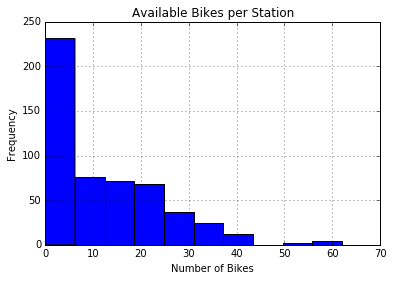

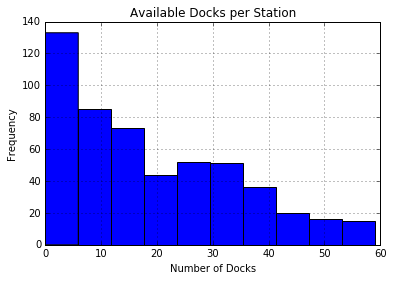

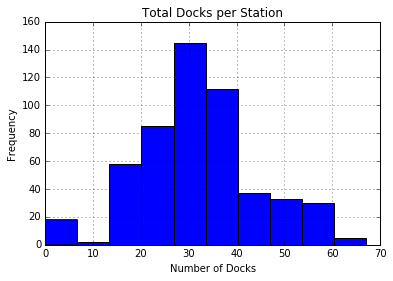

In [6]:
#Probe the dataset
bikedata['availableBikes'].hist()
plt.title('Available Bikes per Station')
plt.xlabel('Number of Bikes')
plt.ylabel('Frequency')

plt.figure()
bikedata['availableDocks'].hist()
plt.title('Available Docks per Station')
plt.xlabel('Number of Docks')
plt.ylabel('Frequency')

plt.figure()
bikedata['totalDocks'].hist()
plt.title('Total Docks per Station')
plt.xlabel('Number of Docks')
plt.ylabel('Frequency')

#Thoughts on histograms
#Each variable has a different distribution which is expected for multiple
#reasons.  There are different constraints and use models depending on the variable
#being considered.  For example, totalDocks appears normally distributed which can
#be explained by a number of reasons.  CitiBike member are most likely not 
#evenly spread across the service area.  Therefore, stations would 
#need different levels of capacity to manage the demand.  
#Another example, availableBikes appears exponentially distributed due to the
#physical lower limit (there can't be negative bikes) and high utilization
#by CitiBike members.  If CitiBike had very low utilization, the distribution
#may match totalDocks more closely.


In [7]:
#Descriptive Statistics
print('Number of Stations: %i' % bikedata['id'].count())
print('Number of Test Stations: %i' % (bikedata['testStation'] == True).sum())
print('Number of In-Service Stations: %i' % (bikedata['statusValue'] == 'In Service').sum())
print('Number of Not-In-Service Stations: %i' % (bikedata['statusValue'] == 'Not In Service').sum())
print('Mean Available Bikes (All Stations): %0.2f' % bikedata['availableBikes'].mean())
print('Median Available Bikes (All Stations): %0.2f' % bikedata['availableBikes'].median())
print('Mean Available Bike (In-Service Stations): %0.2f' % bikedata[bikedata['statusValue']=='In Service']['availableBikes'].mean())

Number of Stations: 525
Number of Test Stations: 0
Number of In-Service Stations: 502
Number of Not-In-Service Stations: 23
Mean Available Bikes (All Stations): 12.08
Median Available Bikes (All Stations): 9.00
Mean Available Bike (In-Service Stations): 12.59


In [8]:
con = lite.connect('citibike.db')
cur = con.cursor()

sql = "INSERT INTO citibike_reference (id, totalDocks, city, altitude, stAddress2, longitude, postalCode, testStation, stAddress1, stationName, landMark, latitude, location) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?)"
idList=bikedata['id'].tolist()
idList=['_'+str(x)+' INT' for x in idList]
with con:
    cur.execute('CREATE TABLE citibike_reference (id INT PRIMARY KEY, totalDocks INT, city TEXT, altitude INT, stAddress2 TEXT, longitude NUMERIC, postalCode TEXT, testStation TEXT, stAddress1 TEXT, stationName TEXT, landMark TEXT, latitude NUMERIC, location TEXT)')
    for station in r.json()['stationBeanList']:
        cur.execute(sql,(station['id'],station['totalDocks'],station['city'],station['altitude'],station['stAddress2'],station['longitude'],station['postalCode'],station['testStation'],station['stAddress1'],station['stationName'],station['landMark'],station['latitude'],station['location']))
    
    cur.execute("CREATE TABLE available_bikes (execution_time INT, " + ", ".join(idList)+");")